In [56]:
import numpy as np
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

In [53]:
from scipy import stats as spstats

def distribute_samples_to_classes(Q, n, shuffle = False):
    ''' 
    Distribute n samples to Q classes
    '''
    rs = 0.6 * np.random.rand(Q) + 0.2 # random sample from [0.2, 0.8)
    z = np.array(np.round((rs / np.sum(rs)) * n), dtype = int)
    z[-1] = n - np.sum(z[:-1])
    tidx = np.arange(n)
    if shuffle:
        np.random.shuffle(tidx)
    bins = np.zeros(Q + 1, dtype = int)
    bins[1:] = np.cumsum(z)
    idx_groups  = [np.sort(tidx[bins[i]:bins[i+1]]) for i in range(Q)]
    labels = [i for idx in range(n) for i in range(Q) if idx in idx_groups[i]]
    return idx_groups, labels

def get_blockdiag_matrix(n, rholist, rhobg, idx_groups):
    ''' 
    Generate a block diagonal matrix of size n x n.
    S_ij = 1, if i = j
         = rholist[q],  if i,j \in idx_groups[q]
         = rhobg, otherwise
    '''
    R = np.ones((n, n)) * rhobg

    for i, (idx, rho) in enumerate(zip(idx_groups, rholist)):
        nblock = idx.shape[0]
        xblock = np.ones((nblock, nblock)) * rho 
        R[np.ix_(idx, idx)] = xblock

    R[np.diag_indices_from(R)] = 1.0 

    return R

def effect_size(n, p, k, Q, h2, g2, 
        aq, a0, nsample, 
        cov_design = 'blockdiag',
        shuffle = False,
        seed = None):
    ''' 
    Get Y = LF' + M + E  where columns of F are orthonormal,
    and L is a blockdiagonal matrix.
    LF' correspond to the shared component of effect sizes,
    the distinct components are given by M, which is sampled
    from a Laplace distribution.
    The noise in the estimate of the effect sizes is given by E.
    '''
    if seed is not None: np.random.seed(seed)
    C_ixgrp, C = distribute_samples_to_classes(Q, n, shuffle = shuffle)
    ggT  = np.sqrt(np.einsum('i,j->ij', g2, g2))
    if cov_design == 'blockdiag':
        rho  = [aq for _ in range(Q)]
        covL = get_blockdiag_matrix(n, rho, a0, C_ixgrp) * ggT 
    else:
        covL = np.eye(n) * ggT 
    # normalize L for correct variance.
    L  = np.random.multivariate_normal(np.zeros(n), covL, size = k).T 
    L /= np.sqrt(k)
    F  = spstats.ortho_group.rvs(p)[:, :k] 
    scaleM = np.sqrt((h2 - g2) * 0.5 / p)
    M = np.random.laplace(np.zeros(n), scaleM, size = (p, n)).T
    # obtain the matrix
    Y0 = L @ F.T 
    covE = np.eye(p) / nsample
    noise = np.random.multivariate_normal(np.zeros(p), covE, size = n)
    Y = Y0 + noise
    return Y, L, F, M, C

In [54]:
n = 500
p = 1000
k = 100
Q = 3
h2 = 0.6
h2_shared_frac = 0.6
aq = 0.6
a0 = 0.2
nsample = 10000

h2array = np.ones(n) * h2
g2array = np.ones(n) * h2 * h2_shared_frac
Y, L, F, M, C = effect_size(
        n, p, k, Q, h2array, g2array, aq, a0, nsample,
        cov_design = 'blockdiag', shuffle = False,
        seed = None)

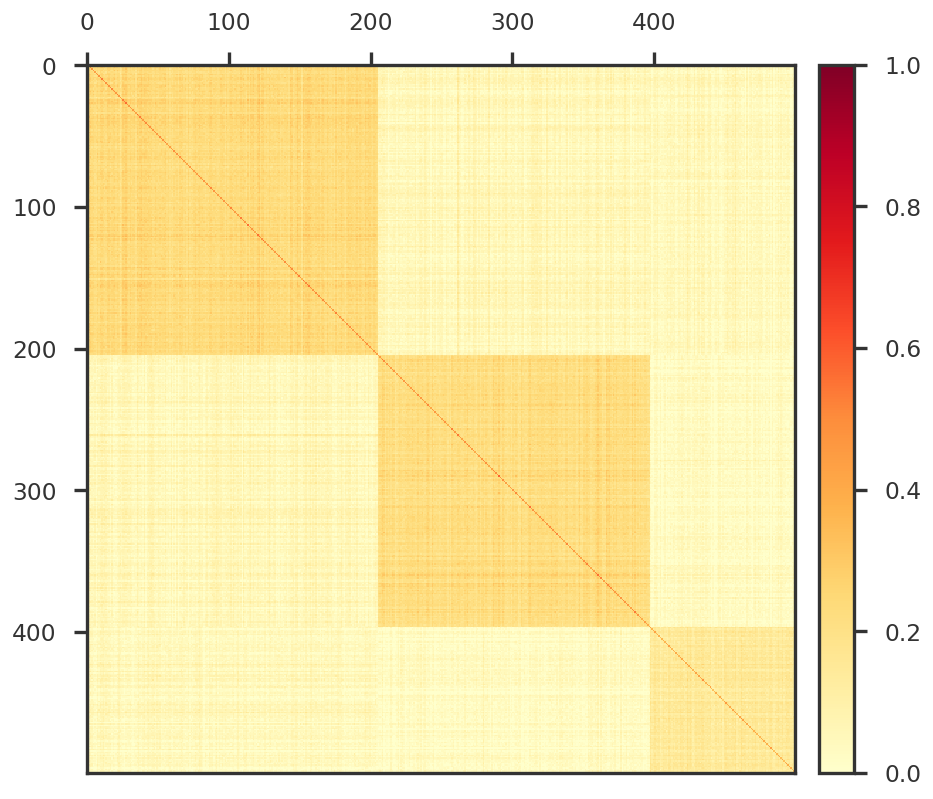

In [65]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

#idxchoice = np.random.choice(nmax, size = nfctr, replace = False)
# diag(cov(Y)) = h2 / P. [see for e.g. eq.58]
# scale Y with P / h2 so that the diagonal elements are 1.
mpy_plotfn.plot_covariance_heatmap(ax1, Y * np.sqrt(p))
#mpy_plotfn.plot_heatmap(ax1, np.cov(Y) / h2)

plt.tight_layout()
plt.show()

In [52]:
np.random.laplace(np.zeros(n), scaleM, size = (p, n))

array([[ 0.00497709,  0.00168154,  0.01172249, ..., -0.07249525,
         0.00590398,  0.00444817],
       [-0.00709314, -0.00984046, -0.00792401, ..., -0.00028352,
        -0.00931836,  0.00040385],
       [ 0.00559331, -0.00085078, -0.00108788, ...,  0.00122074,
        -0.00827317,  0.00978397],
       ...,
       [ 0.01005872,  0.00483947, -0.00194775, ..., -0.01352505,
        -0.00310229,  0.00225305],
       [ 0.00132675, -0.00347866,  0.01516312, ...,  0.00833575,
        -0.01608544,  0.00901879],
       [-0.03345688,  0.00950119,  0.00123566, ..., -0.02009901,
        -0.01008799,  0.00456026]])

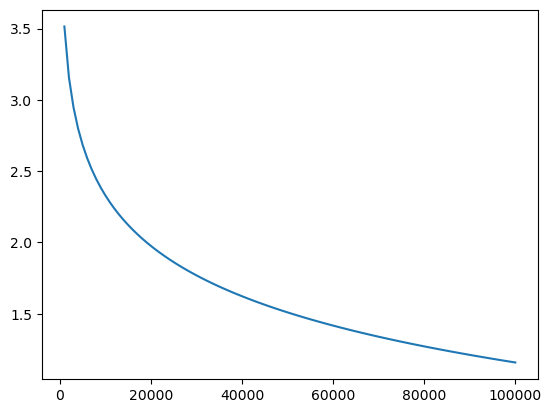

In [25]:
xfin = 1000000
n = 200

xinit = np.linspace(1000, 100000, 100)
r = np.exp(np.log(xfin / xinit)/n) - 1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xinit, r * 100)
plt.show()

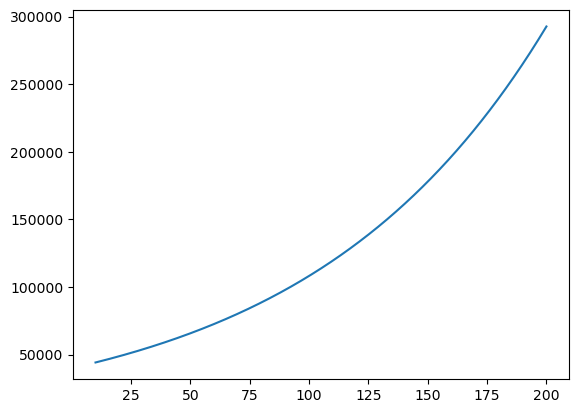

In [39]:
xinit = 40000
r = 0.01
n = np.linspace(10,200,1000)
xfin = xinit * np.power((1. + r), n)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n, xfin)
plt.show()

In [38]:
xfin[-1]

146320.35703659907